In [1]:
import time
import datetime
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# NN model definition

In [2]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.lstm = nn.LSTMCell(self.input_size, self.hidden_size)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, future=0, y=None):
        outputs = []

        # reset the state of LSTM
        # the state is kept till the end of the sequence
        h_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)
        c_t = torch.zeros(input.size(0), self.hidden_size, dtype=torch.float32)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm(input_t.squeeze(1), (h_t, c_t))
            output = self.linear(h_t)

            outputs += [output]

        for i in range(future):
            if y is not None and random.random() > 0.5:
                output = y[:, [i]]  # teacher forcing
            if output.dim()<3:
                output=output.unsqueeze(1)
            h_t, c_t = self.lstm(output.squeeze(1), (h_t, c_t))
            output = self.linear(h_t)
            outputs += [output]
        outputs = torch.stack(outputs, 1)
        return outputs


In [3]:
class Optimization:
    """ A helper class to train, test and diagnose the LSTM"""

    def __init__(self, model, loss_fn, optimizer, scheduler):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_losses = []
        self.val_losses = []
        self.futures = []

    @staticmethod
    def generate_batch_data(x, y, batch_size):
        for batch, i in enumerate(range(0, len(x) - batch_size, batch_size)):
            x_batch = x[i : i + batch_size]
            y_batch = y[i : i + batch_size]
            yield x_batch, y_batch, batch

    def train(
        self,
        x_train,
        y_train,
        x_val=None,
        y_val=None,
        batch_size=4,
        n_epochs=100,
        do_teacher_forcing=None,
    ):
        seq_len = x_train.shape[1]
        for epoch in range(n_epochs):
            start_time = time.time()
            self.futures = []
            train_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_train, y_train, batch_size):
                y_pred = self._predict(x_batch, y_batch, seq_len, do_teacher_forcing)
                self.optimizer.zero_grad()
                loss = self.loss_fn(y_pred, y_batch)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            self.scheduler.step()
            train_loss /= batch
            self.train_losses.append(train_loss)
            self._validation(x_val, y_val, batch_size)

            elapsed = time.time() - start_time
            print(
                "Epoch %d Train loss: %.2f. Validation loss: %.2f. Avg future: %.2f. Elapsed time: %.2fs."
                % (epoch + 1, train_loss, self.val_losses[-1], np.average(self.futures), elapsed)
            )

    def _predict(self, x_batch, y_batch, seq_len, do_teacher_forcing):
        if do_teacher_forcing:
            future = random.randint(1, int(seq_len) // 2)
            limit = x_batch.size(1) - future
            y_pred = self.model(x_batch[:, :limit], future=future, y=y_batch[:, limit:])
        else:
            future = 0
            y_pred = self.model(x_batch)
        self.futures.append(future)
        return y_pred

    def _validation(self, x_val, y_val, batch_size):
        if x_val is None or y_val is None:
            return
        with torch.no_grad():
            val_loss = 0
            for x_batch, y_batch, batch in self.generate_batch_data(x_val, y_val, batch_size):
                y_pred = self.model(x_batch)
                loss = self.loss_fn(y_pred, y_batch)
                val_loss += loss.item()
            val_loss /= batch
            self.val_losses.append(val_loss)

    def evaluate(self, x_test, y_test, batch_size, future=1):
        with torch.no_grad():
            test_loss = 0
            actual, predicted = [], []
            for x_batch, y_batch, batch in self.generate_batch_data(x_test, y_test, batch_size):
                y_pred = self.model(x_batch, future=future)
                y_pred = (
                    y_pred[:, -len(y_batch) :] if y_pred.shape[1] > y_batch.shape[1] else y_pred
                )
                loss = self.loss_fn(y_pred, y_batch)
                test_loss += loss.item()
                actual += torch.squeeze(y_batch[:, -1]).data.cpu().numpy().tolist()
                predicted += torch.squeeze(y_pred[:, -1]).data.cpu().numpy().tolist()
            test_loss /= batch
            return actual, predicted, test_loss

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")

# Auxilliary functions

In [4]:
# Build index in order to transform data into time series
def dateindex_from_weeknum(weeknum, year):
    if weeknum == 1:
        date_str = "" + str(year) + "-01-01"
        dateindex = datetime.datetime.strptime(date_str, "%Y-%m-%d")
    else:
        date_str = "" + str(year) + "-W" + str(weeknum-1) + "-1"
        dateindex = datetime.datetime.strptime(date_str, "%Y-W%W-%w")

    return dateindex

In this implementation I will be looking at sales forecasting from a store in Milan. The same method and ideas can be extended to the other shops/cases (provided that we have data on them).

# Load and clean data

In [5]:
# Milan data
milan_data_df = pd.read_csv("../datasets/dati_nunalie/MILANO/ARESE.csv")
milan_data_df = milan_data_df.append(pd.read_csv("../datasets/dati_nunalie/MILANO/BUSNA.csv"))
milan_data_df = milan_data_df.append(pd.read_csv("../datasets/dati_nunalie/MILANO/PAVIA.csv"))

# Drop unnamed column and listino column, we won't be using those
milan_data_df = milan_data_df.drop(["Unnamed: 0", "listino"], axis=1)

# Build datetime index
milan_data_df["time"] = [dateindex_from_weeknum(week_year[0], week_year[1]) for week_year in milan_data_df[["settimana", "anno"]].values]
milan_data_df = milan_data_df.set_index(["time"])
milan_data_df.index = pd.to_datetime(milan_data_df.index) # make ts

# Sort the data based on the new time index
milan_data_df.sort_index(inplace=True)

# Aggregate the data to get the total sales of each article for every week
milan_data_weekly_articles = milan_data_df.groupby([pd.Grouper(freq = "W-MON"), "codice esterno"]).agg({
    "vendita": np.sum,
    "settimana": np.min, 
    "anno": np.min,
})

# Check for NAN values
print(milan_data_weekly_articles[milan_data_weekly_articles.isnull().any(axis=1)])

# Aggregate the data to get the total sales of each week
milan_data_weekly_totals = milan_data_df.groupby(pd.Grouper(freq = "W-MON")).agg({
    "vendita": np.sum,
    "settimana": np.min, 
    "anno": np.min,
})

# Check for NAN values
print(milan_data_weekly_totals[milan_data_weekly_totals.isnull().any(axis=1)])

# This new grouped df has nan entries so let's replace them.
nan_indices = milan_data_weekly_totals[milan_data_weekly_totals.isnull().any(axis=1)].index
for nan_idx in nan_indices:
    milan_data_weekly_totals.loc[nan_idx, "vendita"] = np.mean(milan_data_weekly_totals.loc[:nan_idx,"vendita"].values)
    milan_data_weekly_totals.loc[nan_idx, "settimana"] = nan_idx.week
    milan_data_weekly_totals.loc[nan_idx, "anno"] = nan_idx.year
    
print(milan_data_weekly_totals[milan_data_weekly_totals.isnull().any(axis=1)])
print("\n\n")    
   
# Drop 2020 data (we won't be using them)
milan_data_weekly_articles.drop(milan_data_weekly_articles.loc["2020"].index, inplace=True)
milan_data_weekly_totals.drop(milan_data_weekly_totals.loc["2020"].index, inplace=True)

print("Weekly sales for each article in Milan stores")
print(milan_data_weekly_articles.head(5))
print(milan_data_weekly_articles.tail(5))
print("\n\n")
print("Total weekly sales in Milan stores")
print(milan_data_weekly_totals.head(5))
print(milan_data_weekly_totals.tail(5))

Empty DataFrame
Columns: [vendita, settimana, anno]
Index: []
            vendita  settimana  anno
time                                
2016-10-03        0        NaN   NaN
2016-10-31        0        NaN   NaN
2016-11-07        0        NaN   NaN
2016-11-14        0        NaN   NaN
2018-10-01        0        NaN   NaN
2018-10-15        0        NaN   NaN
2018-12-31        0        NaN   NaN
Empty DataFrame
Columns: [vendita, settimana, anno]
Index: []



Weekly sales for each article in Milan stores
                           vendita  settimana  anno
time       codice esterno                          
2016-04-11 16SF181BAV-16         3         16  2016
           16SF181BBL-16         1         16  2016
           16SF181BNE-16         3         16  2016
           VA515233NE-16         2         16  2016
           ZR121FABI-16          2         16  2016
                           vendita  settimana  anno
time       codice esterno                          
2019-12-30 XF1781LUGNE-19 

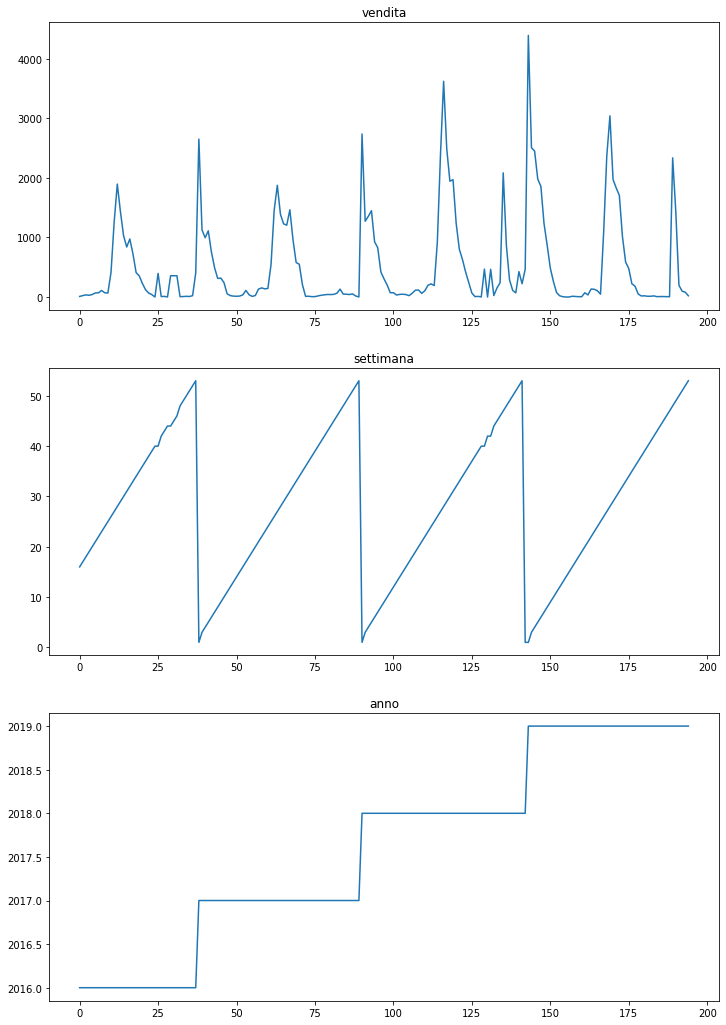

In [6]:
# Plot the data to explore and see what we are working with
values = milan_data_weekly_totals.values
cols_to_plot = [0,1,2]
i=1
plt.figure(figsize=(12,18))
for col in cols_to_plot:
    plt.subplot(len(cols_to_plot), 1, i)
    plt.plot(values[:, col])
    plt.title(milan_data_weekly_totals.columns[col], loc="center")
    i += 1
plt.show()

# Augment the original data by adding new ts data

In [7]:
# Load weather data for milan
milan_weather_df = pd.read_csv("../datasets/Eso_data/weather/milano_weather_data.csv")
milan_weather_df = milan_weather_df.set_index(["DATA"])
# Converting the index as datetime index
milan_weather_df.index = pd.to_datetime(milan_weather_df.index) # make ts

# We can't really group the different weather fenomenons happening each day that column can't be used
# Also the rain and average pressure cols are useless, they only have values of 0 or nan.
# We won't be using those either 
print("Rain mm unique values:", milan_weather_df["PIOGGIA mm"].unique())
print("Avg. pressure unique values:", milan_weather_df["PRESSIONEMEDIA mb"].unique())
milan_weather_df = milan_weather_df.drop(["LOCALITA", "FENOMENI", "PIOGGIA mm", "PRESSIONEMEDIA mb"], axis=1)
# Group data by week (starting with the date 01-01 of the the first year) and aggregate by mean
weekly_milan_weather = milan_weather_df.groupby([pd.Grouper(freq = "W-MON")]).agg(np.mean)
weekly_milan_weather = weekly_milan_weather.fillna(0).astype(int)
# We'll use the average of the daily values to create a weekly value for each one of the columns
milan_weather_df.head(10)

Rain mm unique values: [ 0. nan]
Avg. pressure unique values: [ 0. nan]


,TMEDIA °C,TMIN °C,TMAX °C,PUNTORUGIADA °C,UMIDITA %,VISIBILITA km,VENTOMEDIA km/h,VENTOMAX km/h,RAFFICA km/h,PRESSIONESLM mb
DATA,,,,,,,,,,
2016-01-01,1.0,-2.0,4.0,1.0,97.0,2.0,6.0,11.0,0.0,1026.0
2016-02-01,1.0,0.0,2.0,1.0,97.0,2.0,5.0,9.0,0.0,1019.0
2016-03-01,1.0,0.0,3.0,1.0,96.0,3.0,7.0,11.0,0.0,1010.0
2016-04-01,2.0,1.0,3.0,1.0,93.0,4.0,7.0,11.0,0.0,1000.0
2016-05-01,3.0,2.0,5.0,2.0,89.0,5.0,6.0,11.0,0.0,1001.0
2016-06-01,5.0,3.0,8.0,2.0,85.0,5.0,8.0,13.0,0.0,1001.0
2016-07-01,3.0,-1.0,6.0,2.0,88.0,8.0,5.0,11.0,0.0,1004.0
2016-08-01,2.0,-1.0,5.0,2.0,89.0,7.0,7.0,17.0,0.0,1009.0
2016-09-01,5.0,3.0,5.0,4.0,95.0,2.0,6.0,11.0,0.0,1008.0


In [8]:
# Add the weekly weather data to the total weekly sales dataframe

# Here we add exogenous data we run the train the network with and without these new data. 
# If the prediction improves then we are looking at leading indicator and better forecast accuracy.
milan_data_weekly_augmented = milan_data_weekly_totals.copy(deep=True)
for w_col in weekly_milan_weather.columns:
    milan_data_weekly_augmented[w_col] = weekly_milan_weather.loc[:, w_col]

## Prepare data for the LSTM Network

In [9]:
def ts_train_test_split(df, test_length=0.2):
    # Perform train-test split
    split_index = int(df.shape[0]*test_length)
    train = df[:-split_index]
    test = df[-split_index:]    
    return train, test

In [10]:
def prepare_for_network(train, test):
    # Build the full training and testing dataframes
    #tr_df_denorm = pd.DataFrame(train.values, index=train.index.values, dtype=np.float32, columns=train.columns)
    #te_df_denorm = pd.DataFrame(test.values, index=test.index.values, dtype=np.float32, columns=test.columns)

    # In order to pass the data to the LSTM we need to transform it so it is in the range [-1,1]
    # We scale all our data in order to build the final training and test dataframes
    tr_df = train.copy(deep=True)
    te_df = test.copy(deep=True)
    for col in tr_df.columns:
        #print(tr_df.loc[:, col])
        # mean std Z standardization
        mean = np.mean(train.loc[:,col].values)
        std = np.std(train.loc[:,col].values)
        
        tr_df.loc[:, col] = (train.loc[:,col].values-mean)/std
        te_df.loc[:, col] = (test.loc[:,col].values-mean)/std
        
    
    return tr_df, te_df

In [11]:
def cols_with_most_corr(corr_matrix, forecast_target_col, corr_threshhold=0.10):
    corrmat_row = corr_matrix.iloc[forecast_target_col, :]
    corrmat_row_vals = corrmat_row.values.tolist()
    # Get only the columns that have a correlation coefficient >= corr_threshhold or =< -corr_threshhold
    correlated_features = []
    for val in corrmat_row_vals:
        if (val > corr_threshhold or val < -corr_threshhold):
            correlated_features.append(corrmat_row_vals.index(val))
    return correlated_features

In [12]:
def_train, def_test = ts_train_test_split(milan_data_weekly_totals)
aug_train, aug_test = ts_train_test_split(milan_data_weekly_augmented)

In [13]:
def_tr_df, def_te_df = prepare_for_network(def_train, def_test)
aug_tr_df, aug_te_df = prepare_for_network(aug_train, aug_test)
print("Default training and test sets dimensions:\n", def_tr_df.shape, def_te_df.shape)
print("Augmented training and test sets dimensions:\n", aug_tr_df.shape, aug_te_df.shape)

Default training and test sets dimensions:
 (156, 3) (39, 3)
Augmented training and test sets dimensions:
 (156, 13) (39, 13)


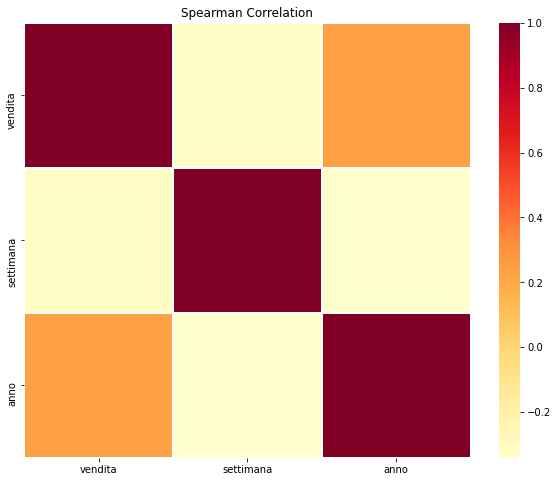

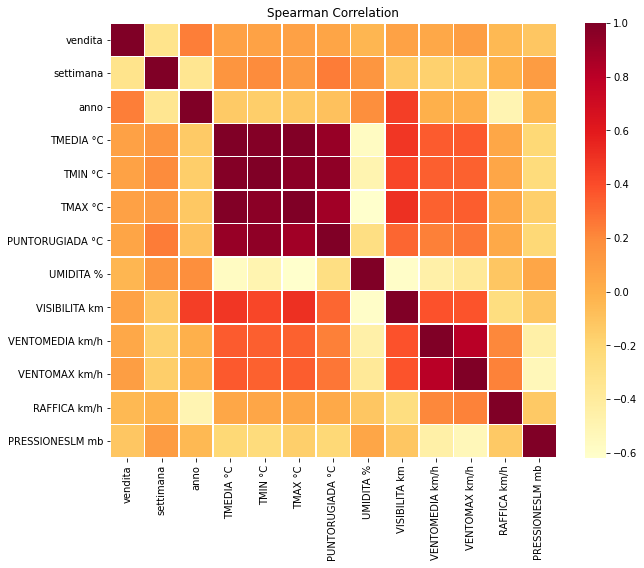

                  vendita  settimana      anno  TMEDIA °C   TMIN °C   TMAX °C  \
vendita          1.000000  -0.314854  0.238620   0.082481  0.073293  0.077818   
settimana       -0.314854   1.000000 -0.341274   0.153058  0.194524  0.118046   
anno             0.238620  -0.341274  1.000000  -0.131768 -0.152973 -0.121301   
TMEDIA °C        0.082481   0.153058 -0.131768   1.000000  0.984767  0.988710   
TMIN °C          0.073293   0.194524 -0.152973   0.984767  1.000000  0.959593   
TMAX °C          0.077818   0.118046 -0.121301   0.988710  0.959593  1.000000   
PUNTORUGIADA °C  0.062156   0.247766 -0.088789   0.923152  0.948214  0.891068   
UMIDITA %       -0.032741   0.141299  0.182398  -0.570864 -0.489828 -0.617953   
VISIBILITA km    0.071025  -0.131762  0.451606   0.486730  0.419821  0.510982   
VENTOMEDIA km/h  0.044108  -0.169930 -0.002190   0.352732  0.341883  0.332763   
VENTOMAX km/h    0.100527  -0.151187  0.003105   0.357876  0.335106  0.347524   
RAFFICA km/h    -0.046378  -

In [27]:
# Normal correlation matrix analysis: Spearman Correlation

## Default df with non-augmented data
default_s_corr = def_tr_df.corr(method="spearman")
plt.figure(figsize=(10,8))
sns.heatmap(data=default_s_corr, cmap="YlOrRd", linewidths=.5)
plt.title("Spearman Correlation")
plt.show()

## Augmented df with weather data
aug_s_corr = aug_tr_df.corr(method="spearman")
plt.figure(figsize=(10,8))
sns.heatmap(data=aug_s_corr, cmap="YlOrRd", linewidths=.5)
plt.title("Spearman Correlation")
plt.show()

print(aug_s_corr)

# Extract the columns which display most correlation with the value we are trying to predict
default_desired_input_features = cols_with_most_corr(default_s_corr, 0)
aug_desired_input_features = cols_with_most_corr(aug_s_corr, 0)
print("Default input features:", default_desired_input_features)
print("Input features with augmented data:", aug_desired_input_features)

In [15]:
def build_in_out_seq(tr_df, te_df, desired_input_features):
    # Building the NN input and outputs. LSTM will expect a supervised learning problem, hence we need to build
    # input sequences that will have output sequences which the model will then learn.

    # Training
    inp_tr = np.stack([tr_df.shift(i).values for i in range(4, 16)], axis=1)[16:, -1::-1, desired_input_features].copy()
    out_tr = np.stack([tr_df.shift(i).values for i in range(4)], axis=1)[16:, -1::-1, desired_input_features].copy()
    # Testing
    inp_te = np.stack([te_df.shift(i).values for i in range(4, 16)], axis=1)[16:, -1::-1, desired_input_features].copy()
    out_te = np.stack([te_df.shift(i).values for i in range(4)], axis=1)[16:, -1::-1, desired_input_features].copy()
    print("Inputs for training")
    print(inp_tr.shape)
    print("Outputs for training")
    print(out_tr.shape)
    print("Inputs for testing")
    print(inp_te.shape)
    print("Outputs for testing")
    print(out_te.shape)
    print("\n")

    return inp_tr, out_tr, inp_te, out_te

In [16]:
def_inp_tr, def_out_tr, def_inp_te, def_out_te = build_in_out_seq(def_tr_df, def_te_df, default_desired_input_features)
aug_inp_tr, aug_out_tr, aug_inp_te, aug_out_te = build_in_out_seq(aug_tr_df, aug_te_df, aug_desired_input_features)

Inputs for training
(140, 12, 3)
Outputs for training
(140, 4, 3)
Inputs for testing
(23, 12, 3)
Outputs for testing
(23, 4, 3)


Inputs for training
(140, 12, 5)
Outputs for training
(140, 4, 5)
Inputs for testing
(23, 12, 5)
Outputs for testing
(23, 4, 5)




In [17]:
# Transform the input and output sequences into PyTorch Tensors in order to feed them to the model
def_x_train=torch.cat((torch.Tensor(def_inp_tr),torch.Tensor(def_out_tr)),1)
def_x_test=torch.Tensor(def_inp_te)
aug_x_train=torch.cat((torch.Tensor(aug_inp_tr),torch.Tensor(aug_out_tr)),1)
aug_x_test=torch.Tensor(aug_inp_te)

# Forecasting using the LSTM Network

In [18]:
def check_results(pred, inp_te, out_te, poll_mean, poll_std):
    # *Data back need to rescaled back to normal*
    plt.title("One step forecast for first 23 test out entries")
    plt.plot(range(0,23),out_te[:23,0,0]*poll_std+poll_mean,label="GT")
    plt.plot(range(0,23),pred[:23,-4,0].detach().cpu().numpy()*poll_std+poll_mean,label="Predictions")
    plt.legend()
    plt.show()

    plt.title("Forecast of 4 weeks (~ 1 month) given 12 (~ 3 months)")
    plt.plot(range(0,16),np.concatenate((inp_te[0,:,0],out_te[0,:,0]),0)*poll_std+poll_mean,label="GT")
    plt.plot(range(12,16),pred[0,-4:,0].detach().cpu().numpy()*poll_std+poll_mean,label="Forecast")
    plt.legend()
    plt.show()

    # Numerical evaluation based on RMSE and MAE 
    rmse = sm.tools.eval_measures.rmse((pred[:, -4,0].detach().cpu().numpy() * poll_std) + poll_mean, ((out_te[:, 0,0] * poll_std) + poll_mean))
    mae = sm.tools.eval_measures.meanabs((pred[:, -4,0].detach().cpu().numpy() * poll_std) + poll_mean, ((out_te[:, 0,0] * poll_std) + poll_mean))
    print("RMSE value:", rmse)
    print("MAE value:", mae)

## Default data

In [19]:
# Build the model and set the preferred loss function, optimizer and scheduler
# All this information is then used in the Optimization helper class.
def_LSTM_Model = Model(input_size=len(default_desired_input_features), hidden_size=80, output_size=len(default_desired_input_features))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(def_LSTM_Model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
def_opt_obj = Optimization(def_LSTM_Model, loss_fn, optimizer, scheduler)

In [20]:
# Train the model on the training data
def_opt_obj.train(def_x_train[:,:-1],def_x_train[:,1:],def_x_train[:,:-1],def_x_train[:,1:], do_teacher_forcing=True, n_epochs=50)

Epoch 1 Train loss: 0.90. Validation loss: 0.76. Avg future: 3.94. Elapsed time: 0.56s.
Epoch 2 Train loss: 0.69. Validation loss: 0.57. Avg future: 3.76. Elapsed time: 0.47s.
Epoch 3 Train loss: 0.52. Validation loss: 0.44. Avg future: 3.82. Elapsed time: 0.49s.
Epoch 4 Train loss: 0.42. Validation loss: 0.38. Avg future: 3.41. Elapsed time: 0.49s.
Epoch 5 Train loss: 0.37. Validation loss: 0.35. Avg future: 3.79. Elapsed time: 0.53s.
Epoch 6 Train loss: 0.33. Validation loss: 0.33. Avg future: 3.91. Elapsed time: 0.51s.
Epoch 7 Train loss: 0.29. Validation loss: 0.31. Avg future: 3.56. Elapsed time: 0.48s.
Epoch 8 Train loss: 0.32. Validation loss: 0.29. Avg future: 4.56. Elapsed time: 0.54s.
Epoch 9 Train loss: 0.32. Validation loss: 0.28. Avg future: 3.94. Elapsed time: 0.53s.
Epoch 10 Train loss: 0.27. Validation loss: 0.28. Avg future: 4.47. Elapsed time: 0.52s.
Epoch 11 Train loss: 0.30. Validation loss: 0.27. Avg future: 4.38. Elapsed time: 0.48s.
Epoch 12 Train loss: 0.27. Val

In [21]:
# Use the model to forecast
def_pred=def_LSTM_Model(def_x_test, 4)

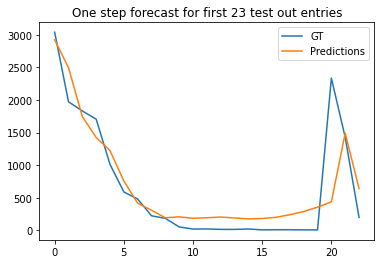

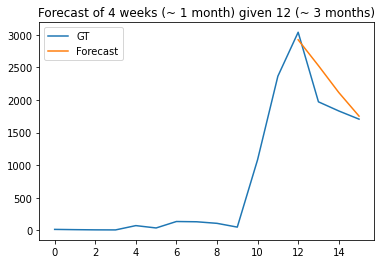

RMSE value: 454.8717535118572
MAE value: 268.99442589801293


In [22]:
# Plot the forecast against the output test data that we have
def_mean = np.mean(def_train["vendita"].values)
def_std = np.std(def_train["vendita"].values)
check_results(def_pred, def_inp_te, def_out_te, def_mean, def_std)

## Augmented data

In [23]:
# Build the model and set the preferred loss function, optimizer and scheduler
# All this information is then used in the Optimization helper class.
aug_LSTM_Model = Model(input_size=len(aug_desired_input_features), hidden_size=50, output_size=len(aug_desired_input_features))
loss_fn = nn.MSELoss()
optimizer = optim.Adam(aug_LSTM_Model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=25, gamma=0.1)
aug_opt_obj = Optimization(aug_LSTM_Model, loss_fn, optimizer, scheduler)

In [24]:
aug_opt_obj.train(aug_x_train[:,:-1],aug_x_train[:,1:],aug_x_train[:,:-1],aug_x_train[:,1:], do_teacher_forcing=True, n_epochs=50)

Epoch 1 Train loss: 0.96. Validation loss: 0.90. Avg future: 4.29. Elapsed time: 0.35s.
Epoch 2 Train loss: 0.87. Validation loss: 0.80. Avg future: 3.56. Elapsed time: 0.37s.
Epoch 3 Train loss: 0.76. Validation loss: 0.70. Avg future: 3.76. Elapsed time: 0.41s.
Epoch 4 Train loss: 0.68. Validation loss: 0.63. Avg future: 3.97. Elapsed time: 0.39s.
Epoch 5 Train loss: 0.61. Validation loss: 0.60. Avg future: 4.38. Elapsed time: 0.43s.
Epoch 6 Train loss: 0.58. Validation loss: 0.57. Avg future: 4.18. Elapsed time: 0.34s.
Epoch 7 Train loss: 0.56. Validation loss: 0.55. Avg future: 4.82. Elapsed time: 0.36s.
Epoch 8 Train loss: 0.54. Validation loss: 0.54. Avg future: 3.41. Elapsed time: 0.38s.
Epoch 9 Train loss: 0.53. Validation loss: 0.53. Avg future: 3.21. Elapsed time: 0.39s.
Epoch 10 Train loss: 0.53. Validation loss: 0.51. Avg future: 3.29. Elapsed time: 0.34s.
Epoch 11 Train loss: 0.50. Validation loss: 0.51. Avg future: 4.32. Elapsed time: 0.37s.
Epoch 12 Train loss: 0.51. Val

In [25]:
aug_pred=aug_LSTM_Model(aug_x_test, 4)

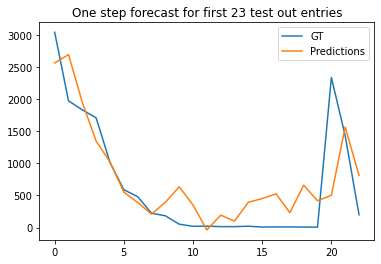

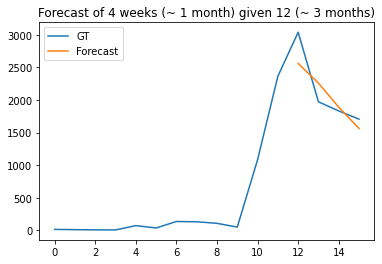

RMSE value: 529.2364095687373
MAE value: 368.45717985733694


In [26]:
aug_mean = np.mean(aug_train["vendita"].values)
aug_std = np.std(aug_train["vendita"].values)
check_results(aug_pred, aug_inp_te, aug_out_te, aug_mean, aug_std)